<a href="https://colab.research.google.com/github/j1ayizhao/datascienceA2/blob/main/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

StudentT's ridge plot shows that the majority of the data is right skewed whereas the skew is not as apparent on the normal ridge plot.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

## normal chem shift model

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

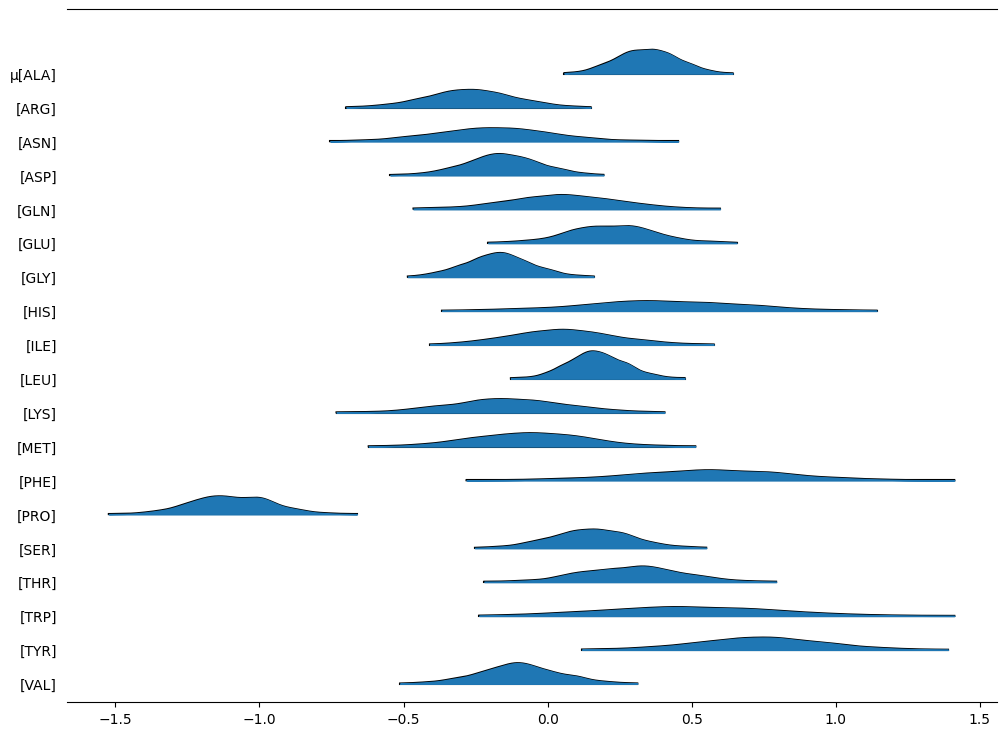

In [ ]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


## new student T model

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model_studentT:
  # hyperpriors
    μ_mu = pm.StudentT('μ_mu', nu=3, mu=0, sigma=10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma=10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ', nu=3, mu=μ_mu, sigma=μ_sd, dims="aa")
    σ = pm.HalfStudentT('σ', nu=3, sigma=10, dims="aa")


    #likelihood
    y = pm.StudentT('y', nu=3, mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data.diff_TminusE)


    #cs for chemshift, h for heirarchical
    idata_cs_h_studentT = pm.sample()

Output()

Output()

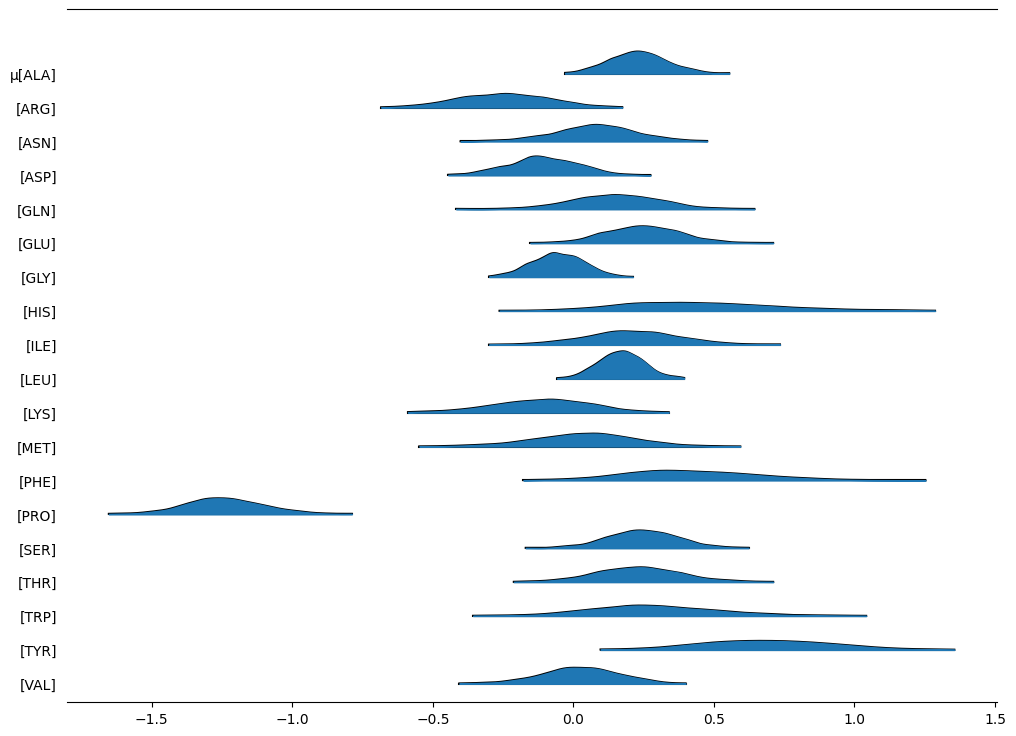

In [ ]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_h_studentT, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

I think the StudentT fits the data better because the posterior predictive mean aligns more closely at the bottom than the normal ppc. But they are both very close in how well they fit the data.

## normal

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

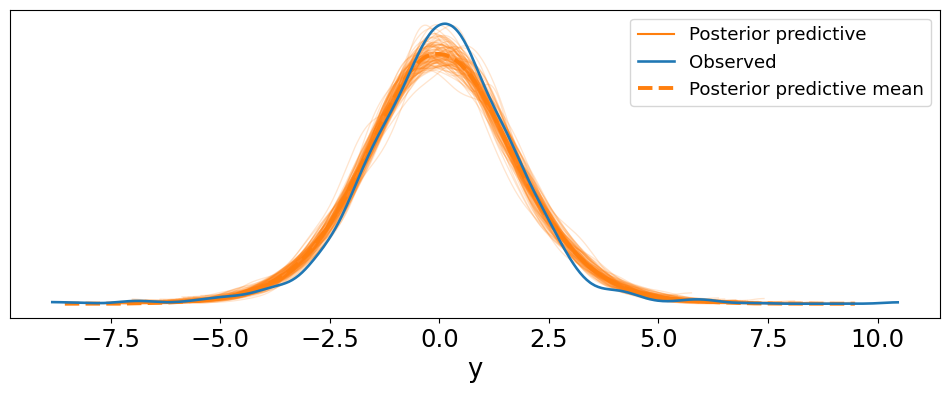

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## studentT

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_studentT, model=cs_h_model_studentT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

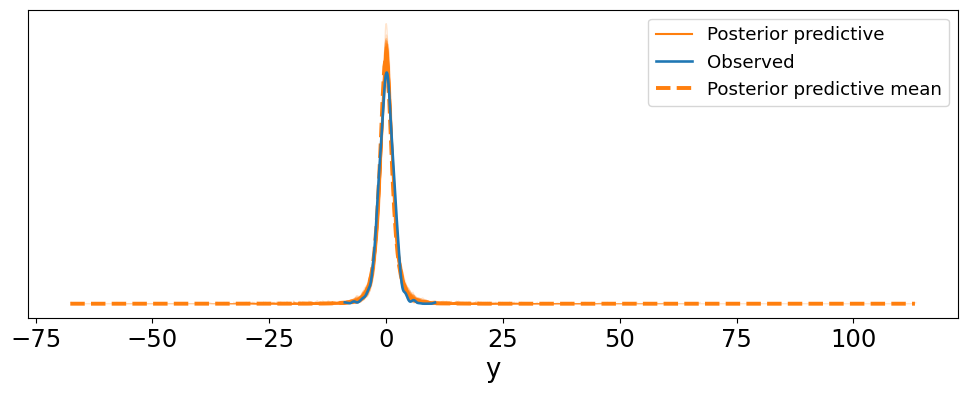

In [ ]:
az.plot_ppc(idata_cs_h_studentT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [2]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [3]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [4]:
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [5]:
with pm.Model(coords = sccr_coords) as sccr_nh_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

The plot trace for theta on the non-hierarchical is different than that of the hierarchical: For the theta plot on the right the maximum is concentrated at 600 while on the hierarchical the maxium is concentrated around 200.
For the μ_p on the right the data seems to be higher than the μ_p on the hierarchical (as seen with the green). For v_p nonhierarchical there are more extreme values, whereas the hierarchical has less extreme values

In general, my non-hierarchical plot trace has more erratic lines, because it estimates each group independently. The hierarchical plot trace is smoother because information is shared between groups which allows it to display the "big picture" of what the data looks like

The non-hierarchical r-hat value for μ_p is lower, theta is higher, v_p is slightly higher

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

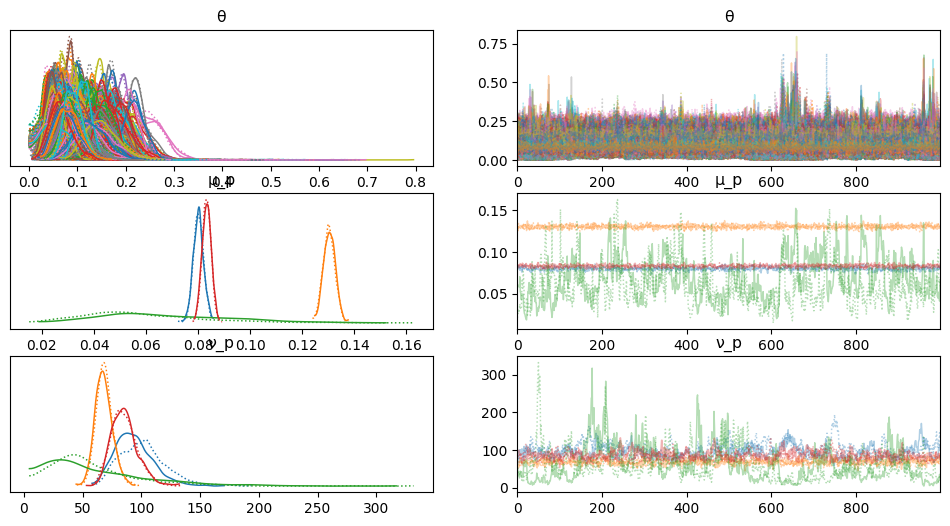

In [6]:
az.plot_trace(idata_sccr_nh)

In [7]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.003 1.006 ... 1.003 1.002 1.004
    μ_p      (pos) float64 32B 1.001 1.003 1.053 1.0
    ν_p      (pos) float64 32B 1.046 1.003 1.08 1.01

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

The ranges of the posterior means for non-hierarchical are smaller than that of the hierarchical

array([<Axes: >], dtype=object)

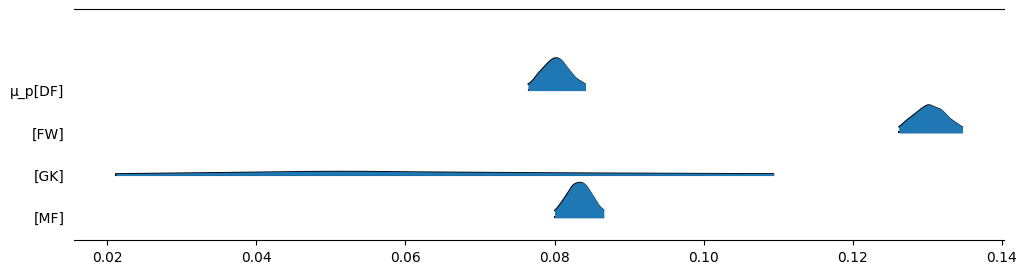

In [10]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.94)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [11]:
no_gk_sccr_data = sccr_data[sccr_data['position'] != 'GK']

In [12]:
pos_idx = no_gk_sccr_data.position.cat.codes.values
pos_codes = no_gk_sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [13]:
with pm.Model(coords=sccr_coords) as sccr_h_no_gk_model:
       # hyperpriors
       μ = pm.Beta('μ', alpha=2, beta=20)
       ν = pm.Gamma('ν', mu=55, sigma=45)

       # priors
       μ_p = pm.Beta('μ_p', alpha=μ, beta=(1 - μ) * ν, dims="pos")
       ν_p = pm.Gamma('ν_p', mu=ν, sigma=45, dims="pos")

       # parameter for players
       θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])

       # likelihood
       _ = pm.Binomial('gs', n=no_gk_sccr_data.shots.values, p=θ, observed=no_gk_sccr_data.goals.values)

       # sample
       idata_sccr_h_no_gk = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?

The hierarchical model without GK
- What do we lose by dropping Gks from the data set? What do we gain?

By dropping GKs from the data set, our prediction for theta is more certain. But also by wiping out the peaks we also lose an important part of the data set because now we don't have comprehensive data for all types of players. If we were just looking to evaluate the field players though, it would be okay to leave out the GKs.

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

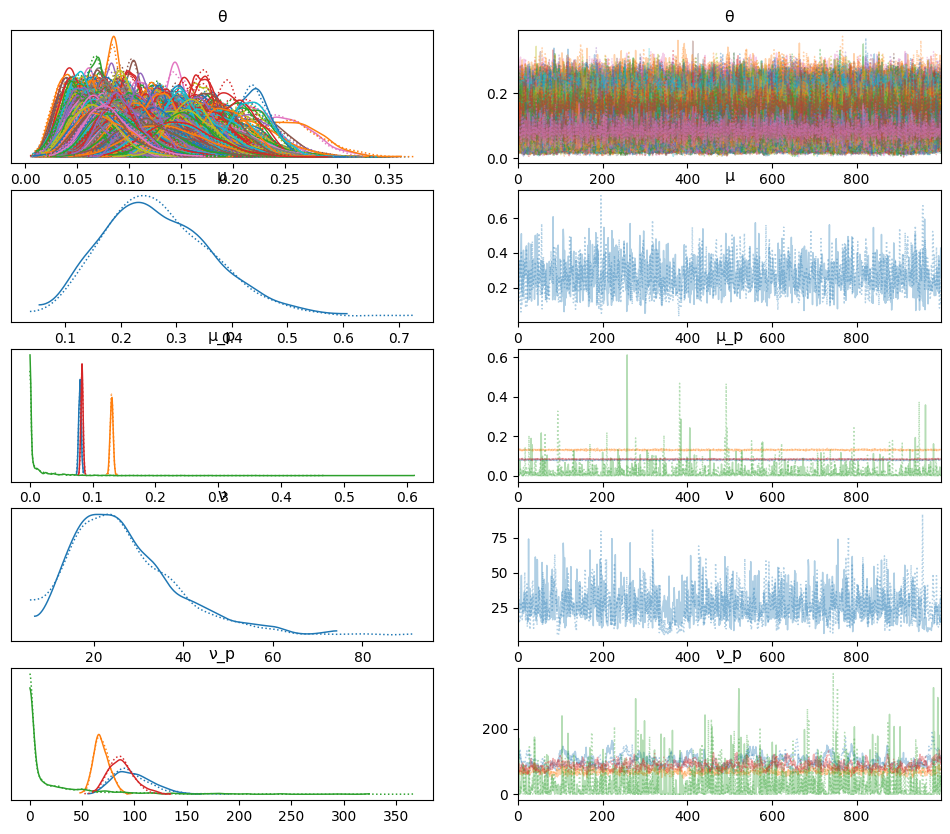

In [14]:
az.plot_trace(idata_sccr_h_no_gk)

In [15]:
az.rhat(idata_sccr_h_no_gk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.004 1.004 ... 0.9995 1.0 0.9996
    μ        float64 8B 1.003
    μ_p      (pos) float64 32B 1.006 1.001 1.002 1.002
    ν        float64 8B 1.009
    ν_p      (pos) float64 32B 1.005 0.9998 1.011 1.006